# Class 4 analysis: the undersampled class

## Imports and data loading

In [65]:
import sys
sys.path.append('..')
import AugmentationHelper

In [66]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
# Setting seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [67]:
data = np.load("../data/class4_samples.npz")

training_set = data.get("training_set")

# Split training set into input images and masks
input_images = training_set[:, 0, :, :]
output_masks = training_set[:, 1, :, :]

print("Input images shape:", input_images.shape)
print("Output masks shape:", output_masks.shape)

n_samples = input_images.shape[0]

Input images shape: (63, 64, 128)
Output masks shape: (63, 64, 128)


In [68]:
colors = ["black", "red", "blue", "green", "yellow"]
bounds = [0, 1, 2, 3, 4, 5]  # Bounds correspond to the intervals between numbers.
norm = mpl.colors.BoundaryNorm(bounds, len(colors))

# Create the colormap
colormap = mpl.colors.ListedColormap(colors)

There are some samples that barely have yellow in them, let's delete them

In [69]:
threshold = 60  # minimum number of yellow pixels in a mask

not_yellow = []
count = []
for i, mask in enumerate(output_masks):
    yellow_count = np.sum(mask == 4)
    if yellow_count <= threshold:
        not_yellow.append(i)
        count.append(f"Yellow pixels count: {yellow_count}")

len(not_yellow)

15

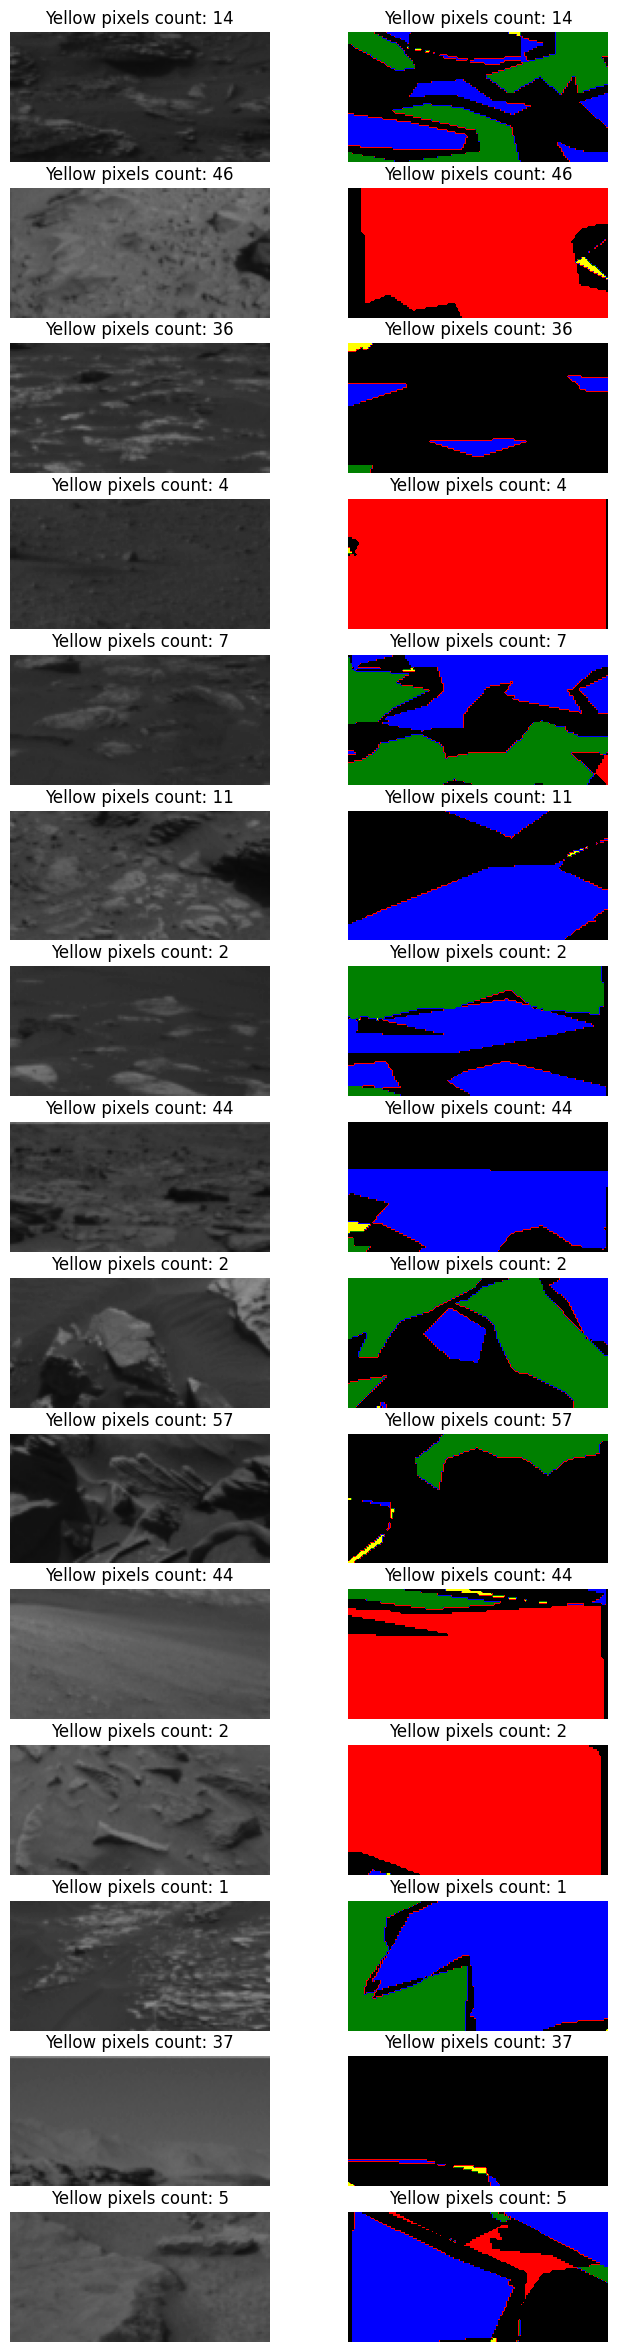

In [70]:
AugmentationHelper.plot_images_and_masks(input_images[not_yellow], output_masks[not_yellow],titles=count, figsize=(8,30))

In [71]:
# delete not enough yellow pictures
images = np.delete(input_images, not_yellow, axis=0)
labels = np.delete(output_masks, not_yellow, axis=0)

images.shape, labels.shape

((48, 64, 128), (48, 64, 128))

## Cropping Big Rock (class 4) -> yellow zones and resizing

(<Axes: title={'center': 'Zoomed Mask'}>,
 Text(0.5, 1.0, 'Zoomed Mask'),
 (-0.5, 127.5, 63.5, -0.5))

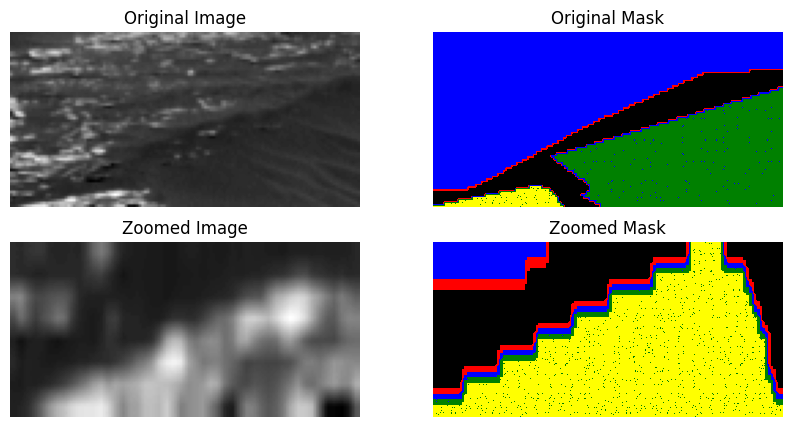

In [72]:
# Apply augmentation
zoomed_image, zoomed_mask = AugmentationHelper.resize_crop(images[0], labels[0])

# Show augmented image and mask
plt.figure(figsize=(10, 5))
plt.subplot(221), plt.imshow(input_images[0], cmap='gray'), plt.title('Original Image'), plt.axis('off')
plt.subplot(222), plt.imshow(output_masks[0], cmap=colormap, norm=norm), plt.title('Original Mask'), plt.axis('off')
plt.subplot(223), plt.imshow(zoomed_image, cmap='gray'), plt.title('Zoomed Image'), plt.axis('off')
plt.subplot(224), plt.imshow(zoomed_mask, cmap=colormap, norm=norm), plt.title('Zoomed Mask'), plt.axis('off')

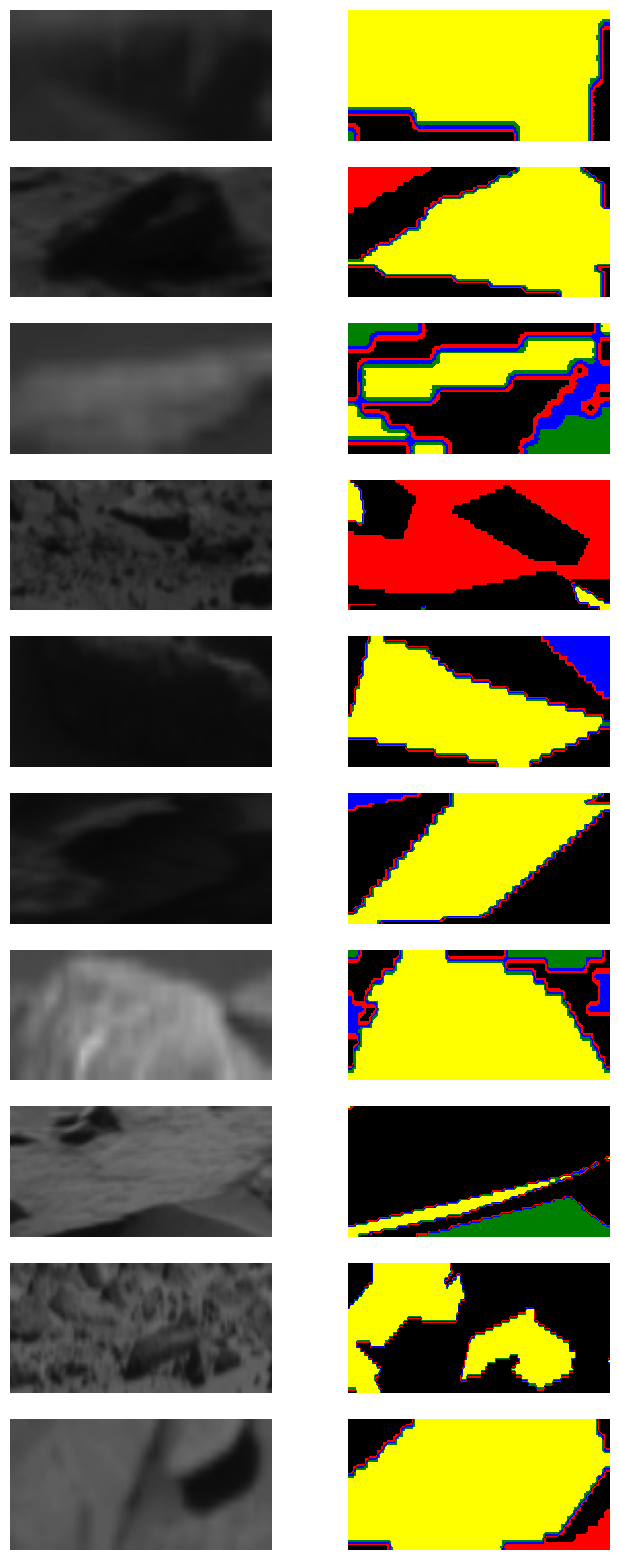

In [73]:
# apply cropping and zooming to all images
zoomed_images = []
zoomed_masks = []
for i in range(images.shape[0]):
    im, mk = AugmentationHelper.resize_crop(images[i], labels[i])
    if (im is not False and mk is not False):
        zoomed_images.append(im)
        zoomed_masks.append(mk)

zoomed_images = np.array(zoomed_images)
zoomed_masks = np.array(zoomed_masks)

# show 5 random augmented images and masks
random_indices = np.random.choice(len(zoomed_images), size=10, replace=False)
AugmentationHelper.plot_images_and_masks(zoomed_images[random_indices], zoomed_masks[random_indices], figsize=(8, 20))

In [74]:
# Concat original and augmented images and masks
all_images = np.concatenate((images, zoomed_images))
all_masks = np.concatenate((labels, zoomed_masks))

all_images.shape, all_masks.shape

((96, 64, 128), (96, 64, 128))

## Augmentation with AugmentationHelper

In [75]:
dataset = tf.data.Dataset.from_tensor_slices((all_images, all_masks))
aug_geometric = dataset.map(AugmentationHelper.map_geometric_transform, num_parallel_calls=tf.data.AUTOTUNE)
aug_intensity = dataset.map(AugmentationHelper.map_intensity_transform, num_parallel_calls=tf.data.AUTOTUNE)
aug_total = dataset.map(AugmentationHelper.map_total_transform, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.concatenate(aug_geometric).concatenate(aug_intensity).concatenate(aug_total)

In [76]:
images, labels = AugmentationHelper.dataset_to_list(dataset)
images = np.array(images)
labels = np.array(labels)
images.shape, labels.shape

((384, 64, 128), (384, 64, 128))

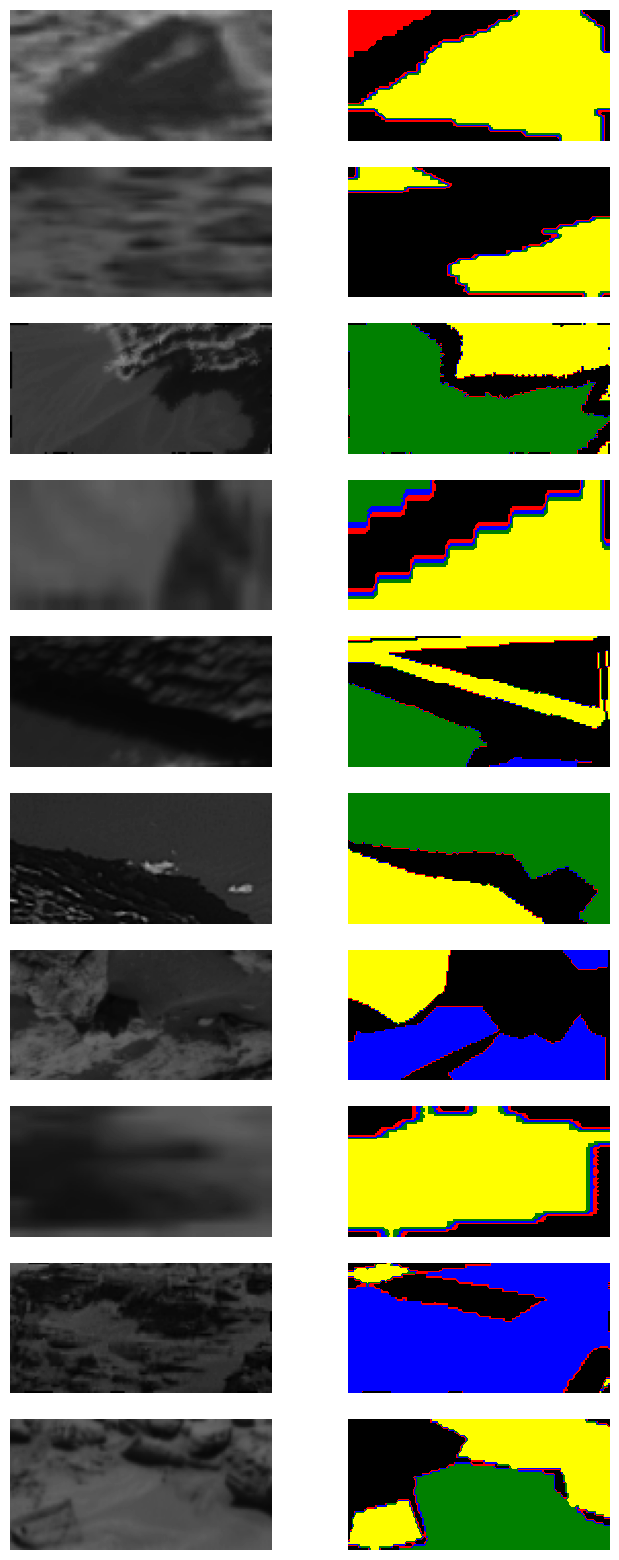

In [77]:
# show 5 random samples
random_indices = np.random.choice(len(dataset), size=10, replace=False)
AugmentationHelper.plot_images_and_masks(images[random_indices], labels[random_indices], figsize=(8, 20))

## Final pixel count

In [78]:
# Step 1: Flatten the masks
flattened_masks = all_masks.flatten()

# Step 2: Count pixels for each class
class_pixel_counts = np.unique(flattened_masks, return_counts=True)[1]

formatted_counts = [f"{count:,}" for count in class_pixel_counts]
print("Class Pixel Counts:", formatted_counts)

Class Pixel Counts: ['364,473', '65,111', '72,699', '111,271', '172,878']
